In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from time import localtime, strftime

In [2]:
dataset = load_dataset("csv", data_files={split: f"../D1/{split}.csv" for split in ["train", "val", "test"]})

In [3]:
dataset["train"][100]

{'id': '110CYL071_95_168',
 'split': 'train',
 'V': 4.0,
 'A': 3.6,
 'D': 3.2,
 'text': 'Think of the joy and success they bring to you and your loved ones.'}

In [4]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def preprocess_data(examples):
    encoding = tokenizer(examples["text"], max_length=128, truncation=True)
    encoding["labels"] = list(zip(examples["V"], examples["A"], examples["D"]))

    return encoding

tokenized_dataset = dataset.map(preprocess_data, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [5]:
def get_model():
    return AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=3)

In [6]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = 4/(1+np.exp(-logits)) + 1

    metrics = {
        "mae": mean_absolute_error(labels, logits, multioutput="raw_values").tolist(),
        "mse": mean_squared_error(labels, logits, multioutput="raw_values").tolist(),
        "pearsonr": [pearsonr(logits[:, i], labels[:, i])[0] for i in range(len(logits[0]))],
        "r_squared": r2_score(labels, logits, multioutput="raw_values").tolist(),
    }

    return {f"{m}_{s}": metrics[m][i] for i, s in enumerate("VAD") for m in metrics}

In [7]:
class RegressionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = torch.sigmoid(outputs['logits']) * 4 + 1
        loss = torch.nn.functional.mse_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [8]:
raise Exception

Exception: 

In [9]:
dir_name = strftime("%b-%d-%y-%H:%M:%S", localtime())

training_args = TrainingArguments(
    output_dir=f"results/{dir_name}",
    logging_dir=f"results/{dir_name}/runs",
    evaluation_strategy="epoch",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    max_grad_norm=1.0,
    num_train_epochs=20,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    logging_strategy="epoch",
    report_to="none",
    save_strategy="epoch",
    seed=42,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
)

trainer = RegressionTrainer(
    model_init=get_model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/2520 [00:00<?, ?it/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.0839, 'learning_rate': 1e-05, 'epoch': 1.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.04961409047245979, 'eval_mae_V': 0.17505162954330444, 'eval_mse_V': 0.058544375002384186, 'eval_pearsonr_V': 0.71692111555935, 'eval_r_squared_V': 0.4928269184388667, 'eval_mae_A': 0.18164171278476715, 'eval_mse_A': 0.053880248218774796, 'eval_pearsonr_A': 0.4615924310778485, 'eval_r_squared_A': 0.14430028018540308, 'eval_mae_D': 0.1420288234949112, 'eval_mse_D': 0.036417584866285324, 'eval_pearsonr_D': 0.3360776731018426, 'eval_r_squared_D': 0.10578804110309092, 'eval_runtime': 0.7079, 'eval_samples_per_second': 1412.537, 'eval_steps_per_second': 22.601, 'epoch': 1.0}
{'loss': 0.0491, 'learning_rate': 2e-05, 'epoch': 2.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.04166313260793686, 'eval_mae_V': 0.15511037409305573, 'eval_mse_V': 0.04515637457370758, 'eval_pearsonr_V': 0.8007805639211255, 'eval_r_squared_V': 0.6088080190574218, 'eval_mae_A': 0.1693948656320572, 'eval_mse_A': 0.045139461755752563, 'eval_pearsonr_A': 0.5771166709120576, 'eval_r_squared_A': 0.2831174584247672, 'eval_mae_D': 0.13966701924800873, 'eval_mse_D': 0.034693580120801926, 'eval_pearsonr_D': 0.4444011271454582, 'eval_r_squared_D': 0.14812079936138112, 'eval_runtime': 0.7003, 'eval_samples_per_second': 1428.039, 'eval_steps_per_second': 22.849, 'epoch': 2.0}
{'loss': 0.0402, 'learning_rate': 1.888888888888889e-05, 'epoch': 3.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.03775230050086975, 'eval_mae_V': 0.14691491425037384, 'eval_mse_V': 0.03934284672141075, 'eval_pearsonr_V': 0.8132964363572041, 'eval_r_squared_V': 0.6591709630802173, 'eval_mae_A': 0.15875951945781708, 'eval_mse_A': 0.04121554642915726, 'eval_pearsonr_A': 0.5890858448648564, 'eval_r_squared_A': 0.3454357046938117, 'eval_mae_D': 0.13413627445697784, 'eval_mse_D': 0.03269854933023453, 'eval_pearsonr_D': 0.47412055990622193, 'eval_r_squared_D': 0.1971069627073686, 'eval_runtime': 0.6931, 'eval_samples_per_second': 1442.848, 'eval_steps_per_second': 23.086, 'epoch': 3.0}
{'loss': 0.0348, 'learning_rate': 1.7777777777777777e-05, 'epoch': 4.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.03788011148571968, 'eval_mae_V': 0.15261387825012207, 'eval_mse_V': 0.04127919301390648, 'eval_pearsonr_V': 0.8241727049995125, 'eval_r_squared_V': 0.6423961166368339, 'eval_mae_A': 0.15855297446250916, 'eval_mse_A': 0.04020551219582558, 'eval_pearsonr_A': 0.6081085075220061, 'eval_r_squared_A': 0.36147564023036516, 'eval_mae_D': 0.1347772777080536, 'eval_mse_D': 0.03215557709336281, 'eval_pearsonr_D': 0.4815382571176167, 'eval_r_squared_D': 0.21043925213656267, 'eval_runtime': 0.7111, 'eval_samples_per_second': 1406.337, 'eval_steps_per_second': 22.501, 'epoch': 4.0}
{'loss': 0.0311, 'learning_rate': 1.6666666666666667e-05, 'epoch': 5.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.03959241509437561, 'eval_mae_V': 0.15257380902767181, 'eval_mse_V': 0.0417105108499527, 'eval_pearsonr_V': 0.8259216690146078, 'eval_r_squared_V': 0.6386596073207174, 'eval_mae_A': 0.16649921238422394, 'eval_mse_A': 0.04459235072135925, 'eval_pearsonr_A': 0.5985336917996062, 'eval_r_squared_A': 0.29180654397877637, 'eval_mae_D': 0.13551495969295502, 'eval_mse_D': 0.03247437998652458, 'eval_pearsonr_D': 0.4946998945742113, 'eval_r_squared_D': 0.20261110724560238, 'eval_runtime': 0.7102, 'eval_samples_per_second': 1408.111, 'eval_steps_per_second': 22.53, 'epoch': 5.0}
{'loss': 0.0278, 'learning_rate': 1.555555555555556e-05, 'epoch': 6.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.03904144465923309, 'eval_mae_V': 0.15126723051071167, 'eval_mse_V': 0.040822893381118774, 'eval_pearsonr_V': 0.8252160122409927, 'eval_r_squared_V': 0.6463493696915029, 'eval_mae_A': 0.16657832264900208, 'eval_mse_A': 0.044364169239997864, 'eval_pearsonr_A': 0.6019376486937611, 'eval_r_squared_A': 0.29543052778833967, 'eval_mae_D': 0.13362225890159607, 'eval_mse_D': 0.031937312334775925, 'eval_pearsonr_D': 0.5016295335162196, 'eval_r_squared_D': 0.21579949305589985, 'eval_runtime': 0.7227, 'eval_samples_per_second': 1383.776, 'eval_steps_per_second': 22.14, 'epoch': 6.0}
{'loss': 0.0255, 'learning_rate': 1.4444444444444446e-05, 'epoch': 7.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.03889092803001404, 'eval_mae_V': 0.14837314188480377, 'eval_mse_V': 0.04091876000165939, 'eval_pearsonr_V': 0.8147998234759574, 'eval_r_squared_V': 0.6455186295573168, 'eval_mae_A': 0.16368718445301056, 'eval_mse_A': 0.042819615453481674, 'eval_pearsonr_A': 0.5995155798264746, 'eval_r_squared_A': 0.3199605826698294, 'eval_mae_D': 0.13635727763175964, 'eval_mse_D': 0.03293443098664284, 'eval_pearsonr_D': 0.4778688440119673, 'eval_r_squared_D': 0.19131535192324833, 'eval_runtime': 0.7218, 'eval_samples_per_second': 1385.367, 'eval_steps_per_second': 22.166, 'epoch': 7.0}
{'loss': 0.0237, 'learning_rate': 1.3333333333333333e-05, 'epoch': 8.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.04169426113367081, 'eval_mae_V': 0.15791656076908112, 'eval_mse_V': 0.04436695575714111, 'eval_pearsonr_V': 0.8188967900549149, 'eval_r_squared_V': 0.6156466024486242, 'eval_mae_A': 0.17012129724025726, 'eval_mse_A': 0.04582389444112778, 'eval_pearsonr_A': 0.5931066297815304, 'eval_r_squared_A': 0.2722479511353447, 'eval_mae_D': 0.14158082008361816, 'eval_mse_D': 0.034891922026872635, 'eval_pearsonr_D': 0.4672120109985656, 'eval_r_squared_D': 0.1432504180453631, 'eval_runtime': 0.7162, 'eval_samples_per_second': 1396.346, 'eval_steps_per_second': 22.342, 'epoch': 8.0}
{'loss': 0.0219, 'learning_rate': 1.2222222222222224e-05, 'epoch': 9.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.04001518338918686, 'eval_mae_V': 0.15123096108436584, 'eval_mse_V': 0.041650671511888504, 'eval_pearsonr_V': 0.81690922801695, 'eval_r_squared_V': 0.6391777821673601, 'eval_mae_A': 0.16781146824359894, 'eval_mse_A': 0.04375877603888512, 'eval_pearsonr_A': 0.5899035318128328, 'eval_r_squared_A': 0.30504489447718086, 'eval_mae_D': 0.1399514228105545, 'eval_mse_D': 0.03463604301214218, 'eval_pearsonr_D': 0.4706971521525015, 'eval_r_squared_D': 0.14953275830087354, 'eval_runtime': 0.7134, 'eval_samples_per_second': 1401.824, 'eval_steps_per_second': 22.429, 'epoch': 9.0}
{'loss': 0.0201, 'learning_rate': 1.1111111111111113e-05, 'epoch': 10.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.04305456578731537, 'eval_mae_V': 0.15901601314544678, 'eval_mse_V': 0.0451841875910759, 'eval_pearsonr_V': 0.8161327594647043, 'eval_r_squared_V': 0.6085671448835663, 'eval_mae_A': 0.1729837954044342, 'eval_mse_A': 0.047239549458026886, 'eval_pearsonr_A': 0.580985762268474, 'eval_r_squared_A': 0.24976477266212815, 'eval_mae_D': 0.14593112468719482, 'eval_mse_D': 0.03673996031284332, 'eval_pearsonr_D': 0.4556346834862791, 'eval_r_squared_D': 0.09787254485875418, 'eval_runtime': 0.7233, 'eval_samples_per_second': 1382.508, 'eval_steps_per_second': 22.12, 'epoch': 10.0}
{'loss': 0.019, 'learning_rate': 1e-05, 'epoch': 11.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.042585235089063644, 'eval_mae_V': 0.15456685423851013, 'eval_mse_V': 0.04379117116332054, 'eval_pearsonr_V': 0.8137983056583362, 'eval_r_squared_V': 0.6206348411297524, 'eval_mae_A': 0.17266155779361725, 'eval_mse_A': 0.04694800078868866, 'eval_pearsonr_A': 0.5751399741664591, 'eval_r_squared_A': 0.2543955429257433, 'eval_mae_D': 0.145879864692688, 'eval_mse_D': 0.03701651841402054, 'eval_pearsonr_D': 0.4509537786171808, 'eval_r_squared_D': 0.09108139058441045, 'eval_runtime': 0.7204, 'eval_samples_per_second': 1388.069, 'eval_steps_per_second': 22.209, 'epoch': 11.0}
{'loss': 0.0177, 'learning_rate': 8.888888888888888e-06, 'epoch': 12.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.040968865156173706, 'eval_mae_V': 0.15106403827667236, 'eval_mse_V': 0.04108825698494911, 'eval_pearsonr_V': 0.8126468509570351, 'eval_r_squared_V': 0.6440505308215263, 'eval_mae_A': 0.17122380435466766, 'eval_mse_A': 0.046015094965696335, 'eval_pearsonr_A': 0.5783156013955941, 'eval_r_squared_A': 0.2692110856708696, 'eval_mae_D': 0.14191168546676636, 'eval_mse_D': 0.03580329194664955, 'eval_pearsonr_D': 0.4514043283504605, 'eval_r_squared_D': 0.12087291367316777, 'eval_runtime': 0.7247, 'eval_samples_per_second': 1379.838, 'eval_steps_per_second': 22.077, 'epoch': 12.0}
{'loss': 0.0166, 'learning_rate': 7.77777777777778e-06, 'epoch': 13.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.04298928380012512, 'eval_mae_V': 0.15269260108470917, 'eval_mse_V': 0.0420307032763958, 'eval_pearsonr_V': 0.8179172316933014, 'eval_r_squared_V': 0.6358857837716152, 'eval_mae_A': 0.17945784330368042, 'eval_mse_A': 0.05007970705628395, 'eval_pearsonr_A': 0.568180708983957, 'eval_r_squared_A': 0.20465933121549207, 'eval_mae_D': 0.14497347176074982, 'eval_mse_D': 0.03685746341943741, 'eval_pearsonr_D': 0.44895793095437225, 'eval_r_squared_D': 0.09498733149495742, 'eval_runtime': 0.7185, 'eval_samples_per_second': 1391.806, 'eval_steps_per_second': 22.269, 'epoch': 13.0}
{'loss': 0.0159, 'learning_rate': 6.666666666666667e-06, 'epoch': 14.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.04197448119521141, 'eval_mae_V': 0.15368930995464325, 'eval_mse_V': 0.04237822815775871, 'eval_pearsonr_V': 0.816191268767829, 'eval_r_squared_V': 0.6328754816202116, 'eval_mae_A': 0.17596007883548737, 'eval_mse_A': 0.04755903780460358, 'eval_pearsonr_A': 0.5629470194537087, 'eval_r_squared_A': 0.24469062915525464, 'eval_mae_D': 0.14370030164718628, 'eval_mse_D': 0.03598618134856224, 'eval_pearsonr_D': 0.4500073793862661, 'eval_r_squared_D': 0.11638174383410971, 'eval_runtime': 0.7212, 'eval_samples_per_second': 1386.605, 'eval_steps_per_second': 22.186, 'epoch': 14.0}
{'loss': 0.0152, 'learning_rate': 5.555555555555557e-06, 'epoch': 15.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.043688639998435974, 'eval_mae_V': 0.15457452833652496, 'eval_mse_V': 0.04229234531521797, 'eval_pearsonr_V': 0.816717985103599, 'eval_r_squared_V': 0.633619132527638, 'eval_mae_A': 0.18017180263996124, 'eval_mse_A': 0.050761185586452484, 'eval_pearsonr_A': 0.5657552736040381, 'eval_r_squared_A': 0.1938364432667412, 'eval_mae_D': 0.14760854840278625, 'eval_mse_D': 0.03801238536834717, 'eval_pearsonr_D': 0.45376746417606917, 'eval_r_squared_D': 0.06662842836379135, 'eval_runtime': 0.7254, 'eval_samples_per_second': 1378.635, 'eval_steps_per_second': 22.058, 'epoch': 15.0}
{'loss': 0.0145, 'learning_rate': 4.444444444444444e-06, 'epoch': 16.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.044260792434215546, 'eval_mae_V': 0.15745188295841217, 'eval_mse_V': 0.044098902493715286, 'eval_pearsonr_V': 0.814057421458551, 'eval_r_squared_V': 0.6179690694079782, 'eval_mae_A': 0.18139953911304474, 'eval_mse_A': 0.051259852945804596, 'eval_pearsonr_A': 0.5594870443933542, 'eval_r_squared_A': 0.18591629237015028, 'eval_mae_D': 0.1459692418575287, 'eval_mse_D': 0.037423621863126755, 'eval_pearsonr_D': 0.45447933587999256, 'eval_r_squared_D': 0.08108576622895891, 'eval_runtime': 0.7203, 'eval_samples_per_second': 1388.234, 'eval_steps_per_second': 22.212, 'epoch': 16.0}
{'loss': 0.0139, 'learning_rate': 3.3333333333333333e-06, 'epoch': 17.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.0436919704079628, 'eval_mae_V': 0.15511101484298706, 'eval_mse_V': 0.04325501248240471, 'eval_pearsonr_V': 0.8155651223341586, 'eval_r_squared_V': 0.6252794548109082, 'eval_mae_A': 0.1797822117805481, 'eval_mse_A': 0.049988988786935806, 'eval_pearsonr_A': 0.5550246717331251, 'eval_r_squared_A': 0.20610014863373904, 'eval_mae_D': 0.14722362160682678, 'eval_mse_D': 0.03783193230628967, 'eval_pearsonr_D': 0.4449537430778484, 'eval_r_squared_D': 0.07106053747128693, 'eval_runtime': 0.7247, 'eval_samples_per_second': 1379.945, 'eval_steps_per_second': 22.079, 'epoch': 17.0}
{'loss': 0.0132, 'learning_rate': 2.222222222222222e-06, 'epoch': 18.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.0426817387342453, 'eval_mae_V': 0.15224093198776245, 'eval_mse_V': 0.04133271053433418, 'eval_pearsonr_V': 0.8160443070912595, 'eval_r_squared_V': 0.6419323700318167, 'eval_mae_A': 0.17947502434253693, 'eval_mse_A': 0.049734801054000854, 'eval_pearsonr_A': 0.5607554772068809, 'eval_r_squared_A': 0.2101363286123895, 'eval_mae_D': 0.14574578404426575, 'eval_mse_D': 0.036977674812078476, 'eval_pearsonr_D': 0.4453606272704081, 'eval_r_squared_D': 0.09203605483243427, 'eval_runtime': 0.7247, 'eval_samples_per_second': 1379.858, 'eval_steps_per_second': 22.078, 'epoch': 18.0}
{'loss': 0.0128, 'learning_rate': 1.111111111111111e-06, 'epoch': 19.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.043221767991781235, 'eval_mae_V': 0.1541161686182022, 'eval_mse_V': 0.04219890385866165, 'eval_pearsonr_V': 0.8168135704141882, 'eval_r_squared_V': 0.6344282672830459, 'eval_mae_A': 0.17939022183418274, 'eval_mse_A': 0.04957588016986847, 'eval_pearsonr_A': 0.5580924312502435, 'eval_r_squared_A': 0.21266044641826665, 'eval_mae_D': 0.1476367563009262, 'eval_mse_D': 0.03789046034216881, 'eval_pearsonr_D': 0.44556733931902764, 'eval_r_squared_D': 0.06962293944777909, 'eval_runtime': 0.7195, 'eval_samples_per_second': 1389.949, 'eval_steps_per_second': 22.239, 'epoch': 19.0}
{'loss': 0.0126, 'learning_rate': 0.0, 'epoch': 20.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.04412180930376053, 'eval_mae_V': 0.1557212620973587, 'eval_mse_V': 0.04308261349797249, 'eval_pearsonr_V': 0.8165524760010573, 'eval_r_squared_V': 0.626773261823715, 'eval_mae_A': 0.1816096305847168, 'eval_mse_A': 0.05114734172821045, 'eval_pearsonr_A': 0.5567776372053967, 'eval_r_squared_A': 0.18770291803492345, 'eval_mae_D': 0.14817306399345398, 'eval_mse_D': 0.03813547641038895, 'eval_pearsonr_D': 0.4461937920774984, 'eval_r_squared_D': 0.06360664580147979, 'eval_runtime': 0.7259, 'eval_samples_per_second': 1377.532, 'eval_steps_per_second': 22.041, 'epoch': 20.0}
{'train_runtime': 430.3531, 'train_samples_per_second': 374.669, 'train_steps_per_second': 5.856, 'train_loss': 0.025477506622435555, 'epoch': 20.0}


TrainOutput(global_step=2520, training_loss=0.025477506622435555, metrics={'train_runtime': 430.3531, 'train_samples_per_second': 374.669, 'train_steps_per_second': 5.856, 'train_loss': 0.025477506622435555, 'epoch': 20.0})

In [ ]:
raise Exception

In [10]:
trainer.evaluate(tokenized_dataset["test"])

  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.03766239061951637,
 'eval_mae_V': 0.14576785266399384,
 'eval_mse_V': 0.038596056401729584,
 'eval_pearsonr_V': 0.8227106141333154,
 'eval_r_squared_V': 0.6760515647148644,
 'eval_mae_A': 0.15978525578975677,
 'eval_mse_A': 0.041764695197343826,
 'eval_pearsonr_A': 0.5623700780741441,
 'eval_r_squared_A': 0.30883861484819897,
 'eval_mae_D': 0.13651259243488312,
 'eval_mse_D': 0.03262639790773392,
 'eval_pearsonr_D': 0.5385059809302638,
 'eval_r_squared_D': 0.26214665523038494,
 'eval_runtime': 0.8013,
 'eval_samples_per_second': 1247.97,
 'eval_steps_per_second': 19.968,
 'epoch': 20.0}

In [11]:
predictions = trainer.predict(tokenized_dataset["test"])

  0%|          | 0/16 [00:00<?, ?it/s]

In [15]:
preds = pd.DataFrame(dataset["test"]).drop(["id", "split"], axis=1)[["text", "V", "A", "D"]]
preds[["V_hat", "A_hat", "D_hat"]] = 4/(1+np.exp(-predictions[0])) + 1

In [16]:
preds

,text,V,A,D,V_hat,A_hat,D_hat
0,If I wasn't working here.,2.80,3.10,2.80,2.830777,2.989581,2.980869
1,"I've got more than a job; I've got a career.""",3.27,3.36,3.36,3.344175,3.260056,3.317862
2,He has no time to waste.,2.86,3.29,3.29,3.049323,3.045223,3.172736
3,"With the help of friends like you, Goodwill ha...",3.40,3.10,3.40,3.294815,3.032731,3.099004
4,Real results.,3.00,2.60,3.10,3.015378,2.881243,3.110896
...,...,...,...,...,...,...,...
995,"A final statement yesterday said: ""While some ...",2.30,3.50,2.30,2.455417,3.102869,2.876798
996,"""Noriega has closed every independent newspape...",2.14,3.43,2.71,2.445255,3.205246,2.975209
997,"Robert Merkel, a former U.S. attorney handling...",2.67,3.11,3.11,2.858377,3.012497,3.042310
998,"The challenges we face are daunting, to be sure.",2.56,3.22,2.89,2.720838,3.119452,2.917352


<Axes: xlabel='D', ylabel='D_hat'>

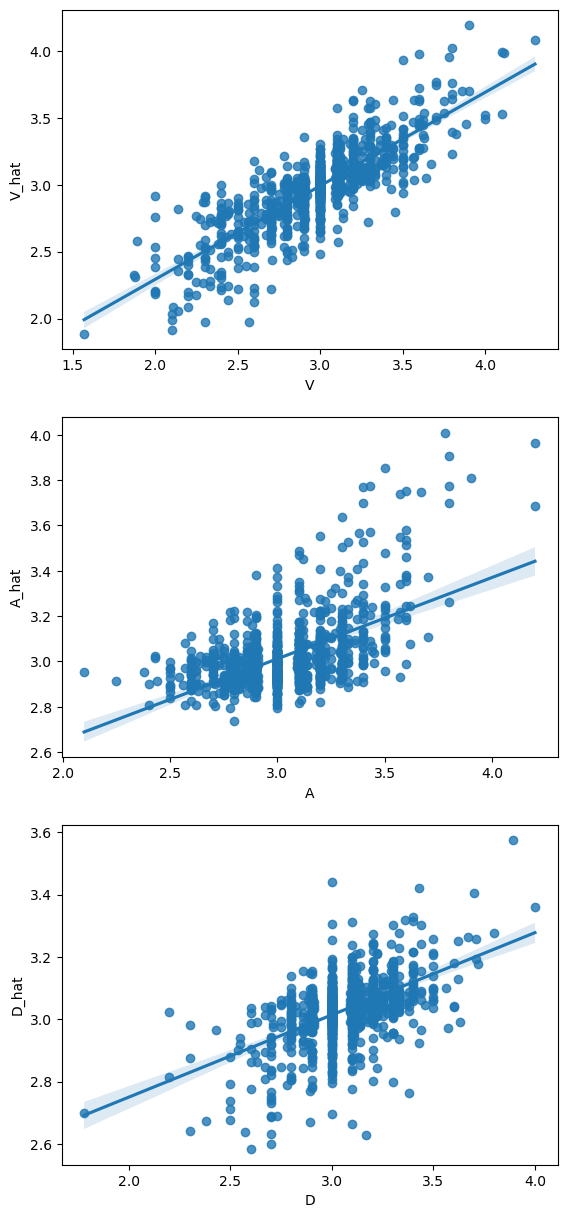

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(nrows=3)
fig.set_figheight(15)
sns.regplot(preds, x="V", y="V_hat", ax=axs[0])
sns.regplot(preds, x="A", y="A_hat", ax=axs[1])
sns.regplot(preds, x="D", y="D_hat", ax=axs[2])

In [ ]:
df = pd.DataFrame(dataset["train"])

In [ ]:
df['A'].describe()

count    8062.000000
mean        3.044065
std         0.262184
min         1.800000
25%         2.890000
50%         3.000000
75%         3.200000
max         4.400000
Name: A, dtype: float64

In [ ]:
df['V'].describe()

count    8062.000000
mean        2.978343
std         0.350204
min         1.200000
25%         2.800000
50%         3.000000
75%         3.120000
max         4.600000
Name: V, dtype: float64

In [ ]:
p = [x/100 for x in range(5, 105, 5)]

<Axes: >

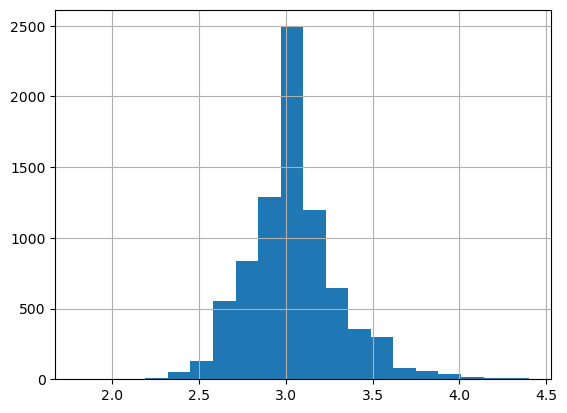

In [ ]:
df['A'].hist(bins=20)

In [ ]:
stat = df['D'].describe(percentiles=p)
display(stat)
display(stat.iloc[4:].cumsum())

count    8062.000000
mean        3.062708
std         0.210554
min         2.000000
5%          2.700000
10%         2.800000
15%         2.890000
20%         2.900000
25%         3.000000
30%         3.000000
35%         3.000000
40%         3.000000
45%         3.000000
50%         3.090000
55%         3.100000
60%         3.100000
65%         3.110000
70%         3.140000
75%         3.200000
80%         3.200000
85%         3.250000
90%         3.300000
95%         3.400000
100%        4.200000
max         4.200000
Name: D, dtype: float64

5%       2.70
10%      5.50
15%      8.39
20%     11.29
25%     14.29
30%     17.29
35%     20.29
40%     23.29
45%     26.29
50%     29.38
55%     32.48
60%     35.58
65%     38.69
70%     41.83
75%     45.03
80%     48.23
85%     51.48
90%     54.78
95%     58.18
100%    62.38
max     66.58
Name: D, dtype: float64

<Axes: >

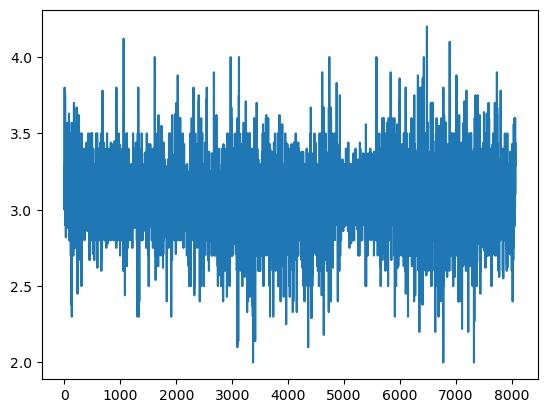

In [ ]:
df['D'].plot()

<Axes: >

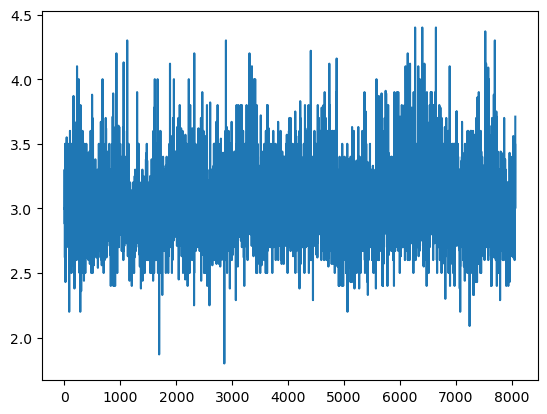

In [ ]:
df['A'].plot()

<Axes: >

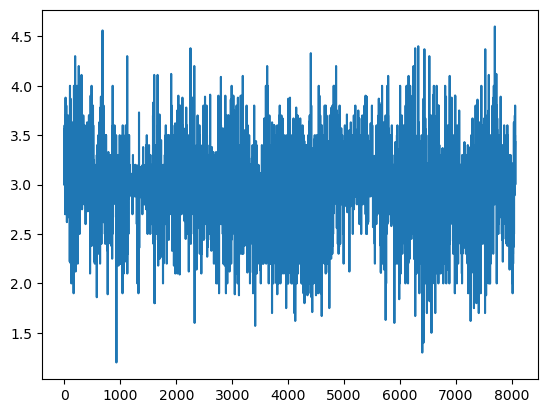

In [ ]:
df['V'].plot()